In [63]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import circmean, circstd
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from typing import List
#import h5py
from imaging_behavior_functions import (
    load_intermediate_mat,
    make_df_behavior,
    reconstruct_path,
    get_roi_seq,
    load_dff_raw,
    make_df_neural,
    merge_dataframes,
    fit_sinusoid,
    calculate_theta_g_rho
)
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import entropy
from scipy.signal import welch
from scipy.spatial.distance import pdist, squareform

In [2]:
# functions for characterizing the odor state

def analyze_odor_time_series(df, odor_col="odor_state", time_col="time"):
    """
    Computes various metrics from an odor stimulus time series.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with 'time' and 'odor_state' (binary 0/1).
    - odor_col (str): Column name for odor state (default: 'odor_state').
    - time_col (str): Column name for time values (default: 'time').
    
    Returns:
    - dict: Computed metrics.
    """
    results = {}

    # Ensure time is sorted
    df = df.sort_values(by=time_col).reset_index(drop=True)
    
    # Compute transitions
    transitions = df[odor_col].diff().dropna().abs()  # 1 for state change, 0 otherwise
    num_transitions = transitions.sum()
    total_time = df[time_col].iloc[-1] - df[time_col].iloc[0]

    # Mean transition rate
    results["mean_transition_rate"] = num_transitions / total_time if total_time > 0 else 0

    # Compute inter-event intervals (time between transitions)
    transition_times = df[time_col][transitions > 0].values
    inter_event_intervals = np.diff(transition_times)

    if len(inter_event_intervals) > 1:
        results["inter_event_interval_mean"] = np.mean(inter_event_intervals)
        results["inter_event_interval_std"] = np.std(inter_event_intervals)
        results["fano_factor"] = np.var(inter_event_intervals) / np.mean(inter_event_intervals) if np.mean(inter_event_intervals) > 0 else 0
    else:
        results["inter_event_interval_mean"] = 0
        results["inter_event_interval_std"] = 0
        results["fano_factor"] = 0

    # Shannon Entropy of state probabilities
    p_on = df[odor_col].mean()
    p_off = 1 - p_on
    results["shannon_entropy"] = entropy([p_on, p_off], base=2) if p_on > 0 and p_off > 0 else 0

    # Conditional Entropy: Approximate using transition probabilities
    P_on_to_off = num_transitions / df[odor_col].sum() if df[odor_col].sum() > 0 else 0
    P_off_to_on = num_transitions / (len(df) - df[odor_col].sum()) if (len(df) - df[odor_col].sum()) > 0 else 0

    if P_on_to_off > 0 and P_off_to_on > 0:
        results["conditional_entropy"] = - (P_on_to_off * np.log2(P_on_to_off) + P_off_to_on * np.log2(P_off_to_on))
    else:
        results["conditional_entropy"] = 0

    # Power Spectrum Analysis (Fourier Transform for frequency content)
    fs = 1 / np.median(np.diff(df[time_col])) if len(df) > 1 else 1  # Sampling frequency
    f, Pxx = welch(df[odor_col], fs=fs, nperseg=min(256, len(df)))
    results["dominant_frequency"] = f[np.argmax(Pxx)] if len(f) > 0 else 0

    # Duty Cycle
    results["duty_cycle"] = p_on

    # Autocorrelation (First Lag)
    if len(df) > 1:
        autocorr = np.corrcoef(df[odor_col][:-1], df[odor_col][1:])[0, 1]
        results["autocorrelation_first_lag"] = autocorr if not np.isnan(autocorr) else 0
    else:
        results["autocorrelation_first_lag"] = 0

    return results

# Example Usage
# df = pd.DataFrame({'time': np.arange(0, 100, 1), 'odor_state': np.random.choice([0, 1], size=100)})
# results = analyze_odor_time_series(df)
# print(results)


In [144]:
def compute_odor_metrics_2(df, heading_window_size=5, burstiness_window=5, novelty_weight=0.5):
    """
    Computes odor-related event metrics, including onset/offset-based calculations and 
    event-specific sensory information.

    Parameters:
    - df (pd.DataFrame): Must contain 'odor_state', 'time', and 'heading' columns.
    - heading_window_size (float): Time window before onset to average heading.
    - burstiness_window (int): Number of prior intervals to use for burstiness score.
    - novelty_weight (float): Weight factor for novelty score calculation.

    Returns:
    - pd.DataFrame with additional computed columns.
    """
    onset_indices = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    offset_indices = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    # Initialize new columns
    df["odor_duration"] = np.nan
    df["past_interval"] = np.nan
    df["odor_heading_avg"] = np.nan
    df["prior_odor_duration"] = np.nan

    # New metrics
    df["surprise_index"] = np.nan
    df["adaptation_index"] = np.nan
    df["novelty_score"] = np.nan
    df["burstiness_score"] = np.nan

    last_odor_duration = 0  # Default for the first odor encounter
    prior_intervals = []  # Store prior intervals for burstiness calculation

    for i, onset_idx in enumerate(onset_indices):
        # Find the first offset after the onset
        offset_idx = offset_indices[offset_indices > onset_idx].min()

        if pd.notna(offset_idx):
            # Compute odor duration
            odor_duration = df.loc[offset_idx, "time"] - df.loc[onset_idx, "time"]
            df.loc[onset_idx, "odor_duration"] = odor_duration
            df.loc[onset_idx, "prior_odor_duration"] = last_odor_duration
            last_odor_duration = odor_duration  # Update for next iteration
        else:
            df.loc[onset_idx, "prior_odor_duration"] = last_odor_duration

        # Compute past interval (ISI)
        last_offset_idx = offset_indices[offset_indices < onset_idx].max()
        if pd.notna(last_offset_idx):
            past_interval = df.loc[onset_idx, "time"] - df.loc[last_offset_idx, "time"]
        else:
            past_interval = df.loc[onset_idx, "time"] - df["time"].iloc[0]

        df.loc[onset_idx, "past_interval"] = past_interval
        prior_intervals.append(past_interval)

        # Compute Surprise Index (Higher for longer past intervals)
        df.loc[onset_idx, "surprise_index"] = past_interval

        # Compute Adaptation Index (Ratio of prior duration to prior interval, avoid division by zero)
        df.loc[onset_idx, "adaptation_index"] = np.nan if past_interval == 0 else last_odor_duration / past_interval

        # Compute Novelty Score (penalizes long prior odor durations)
        df.loc[onset_idx, "novelty_score"] = past_interval - (novelty_weight * last_odor_duration)

        # Compute Burstiness Score (variability of past K intervals)
        if len(prior_intervals) > 1:
            windowed_intervals = prior_intervals[max(0, i - burstiness_window):i]
            if len(windowed_intervals) > 1:
                burstiness = np.std(windowed_intervals) / np.mean(windowed_intervals) if np.mean(windowed_intervals) > 0 else np.nan
            else:
                burstiness = np.nan
        else:
            burstiness = np.nan

        df.loc[onset_idx, "burstiness_score"] = burstiness

        # Compute average heading before onset
        onset_time = df.loc[onset_idx, "time"]
        window_start_time = onset_time - heading_window_size
        heading_window = df[(df["time"] >= window_start_time) & (df["time"] < onset_time)]["heading"]

        if not heading_window.empty:
            df.loc[onset_idx, "odor_heading_avg"] = circmean(heading_window)

    # Set first encounter's prior odor duration to 0
    first_onset_idx = onset_indices.min()
    if pd.notna(first_onset_idx):
        df.loc[first_onset_idx, "prior_odor_duration"] = 0

    return df

# TODO: fix offet calculation part
def compute_event_metrics_3(df, state_col="odor_state", time_col="time", heading_col="heading", 
                          heading_window_size=5, burstiness_window=5, novelty_weight=0.5):
    """
    Computes event-based metrics for both ON and OFF transitions of a binary state variable.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with binary state variable (e.g., odor presence).
    - state_col (str): Name of the binary column indicating event presence (0 or 1).
    - time_col (str): Name of the time column.
    - heading_col (str): Name of the heading column.
    - heading_window_size (float): Time window before an event to average heading.
    - burstiness_window (int): Number of prior intervals to use for burstiness score.
    - novelty_weight (float): Weight factor for novelty score calculation.

    Returns:
    - pd.DataFrame with additional computed columns at both ON and OFF transitions.
    """

    onset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 0) & (df[state_col] == 1)]
    offset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 1) & (df[state_col] == 0)]

    # Initialize new columns
    df["event_duration"] = np.nan
    df["past_interval"] = np.nan
    df["prior_event_duration"] = np.nan
    df["heading_avg"] = np.nan

    # Additional sensory processing metrics
    df["surprise_index"] = np.nan
    df["adaptation_index"] = np.nan
    df["novelty_score"] = np.nan
    df["burstiness_score"] = np.nan

    last_event_duration = 0  # Default for the first encounter
    prior_intervals = []  # Store prior intervals for burstiness calculation

    all_indices = np.sort(np.concatenate([onset_indices, offset_indices]))  # Order all events

    for i, event_idx in enumerate(all_indices):
        is_onset = event_idx in onset_indices
        event_label = "ON" if is_onset else "OFF"

        # Find matching onset or offset for duration calculation
        if is_onset:
            matching_offset_idx = offset_indices[offset_indices > event_idx].min()
        else:
            matching_onset_idx = onset_indices[onset_indices > event_idx].min()
        
        # Compute event duration
        if is_onset and pd.notna(matching_offset_idx):
            event_duration = df.loc[matching_offset_idx, time_col] - df.loc[event_idx, time_col]
        elif not is_onset and pd.notna(matching_onset_idx):
            event_duration = df.loc[event_idx, time_col] - df.loc[matching_onset_idx, time_col]
        else:
            event_duration = np.nan

        df.loc[event_idx, "event_duration"] = event_duration
        df.loc[event_idx, "prior_event_duration"] = last_event_duration
        last_event_duration = event_duration  # Update for next iteration

        # Compute past interval (ISI)
        prev_event_idx = all_indices[all_indices < event_idx].max() if i > 0 else None
        if pd.notna(prev_event_idx):
            past_interval = df.loc[event_idx, time_col] - df.loc[prev_event_idx, time_col]
        else:
            past_interval = df.loc[event_idx, time_col] - df[time_col].iloc[0]

        df.loc[event_idx, "past_interval"] = past_interval
        prior_intervals.append(past_interval)

        # Compute Surprise Index (Higher for longer past intervals)
        df.loc[event_idx, "surprise_index"] = past_interval

        # Compute Adaptation Index (Ratio of prior duration to prior interval, avoid division by zero)
        df.loc[event_idx, "adaptation_index"] = np.nan if past_interval == 0 else last_event_duration / past_interval

        # Compute Novelty Score (penalizes long prior event durations)
        df.loc[event_idx, "novelty_score"] = past_interval - (novelty_weight * last_event_duration)

        # Compute Burstiness Score (variability of past K intervals)
        if len(prior_intervals) > 1:
            windowed_intervals = prior_intervals[max(0, i - burstiness_window):i]
            if len(windowed_intervals) > 1:
                burstiness = np.std(windowed_intervals) / np.mean(windowed_intervals) if np.mean(windowed_intervals) > 0 else np.nan
            else:
                burstiness = np.nan
        else:
            burstiness = np.nan

        df.loc[event_idx, "burstiness_score"] = burstiness

        # Compute average heading before the event (if heading data is available)
        event_time = df.loc[event_idx, time_col]
        window_start_time = event_time - heading_window_size
        heading_window = df[(df[time_col] >= window_start_time) & (df[time_col] < event_time)][heading_col]

        if not heading_window.empty:
            df.loc[event_idx, "heading_avg"] = circmean(heading_window)

    # Ensure first encounter's prior duration is set to 0
    first_event_idx = all_indices.min()
    if pd.notna(first_event_idx):
        df.loc[first_event_idx, "prior_event_duration"] = 0

    return df



In [40]:
def extract_heatmap(df, roi_kw, roi_kw2):
    if roi_kw2:
        filtered_columns = [col for col in df.columns if roi_kw in col and roi_kw2 not in col]
        roi_mtx = df[filtered_columns]
    else:
        roi_mtx = df[[col for col in df.columns if roi_kw.lower() in col.lower()]]
    if roi_mtx.empty:
        return None
    scaler = StandardScaler()
    roi_mtx = scaler.fit_transform(roi_mtx)
    return roi_mtx

In [146]:
def make_merged_df(example_path_data,  trial_num):
    # Load data and preprocess
    print(example_path_data)
    is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data, trial_num)
    behav_df = make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
    behav_df = reconstruct_path(behav_df, ball_d=9)
    # calculate straightness
    behav_df = calculate_theta_g_rho(behav_df)
    # odor related variable processing
    if 'odor_state' in behav_df.columns:
        behav_df = compute_event_metrics_3(behav_df)
        #behav_df = compute_event_metrics(behav_df)
    roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
    dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
    neural_df = make_df_neural(
        dff_all_rois,
        dff_time,
        roi_names,
        hdeltab_index,
        epg_index,
        fr1_index,
        hdeltab_sequence,
        epg_sequence,
        fr1_sequence,
    )
    roi_kw = 'hDeltaB'
    roi_kw2 = 'MB'
    if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
        #print(1)
        roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2)
        neural_df,paramfit_df = fit_sinusoid(neural_df,roi_mtx)
    merged_df = merge_dataframes(behav_df, neural_df)
    return merged_df

In [147]:
def contains_keyword(df, keyword):
    return df.astype(str).apply(lambda col: col.str.contains(keyword, na=False)).any().any()

def process_all_trials(base_path, odor_threshold=5, time_interval_threshold=16, k=8, window_size=30):
    all_data = []
    flyid = 0

    # Iterate over each folder in the base path
    for fly_folder in os.listdir(base_path):
        fly_folder_path = os.path.join(base_path, fly_folder)

        if not os.path.isdir(fly_folder_path):
            continue

        data_path = fly_folder_path +"/data/"

        if not os.path.exists(data_path):
            print(f"Data folder not found: {data_path}")
            continue

        # Find all trial numbers by checking files like dff_raw_trialx.mat
        trial_files = [f for f in os.listdir(data_path) if re.match(r"dff raw trial\d+\.mat", f)]
        trial_numbers = [int(re.search(r"\d+", f).group()) for f in trial_files]

        for trial_num in trial_numbers:
            try:
                # Load the intermediate MAT file
                merged_df = make_merged_df(data_path, trial_num)
                # Combine behavioral and neural dataframes

                # Add flyid and trialid columns
                merged_df["flyid"] = flyid
                merged_df["trialid"] = trial_num

                # Append to all_data
                all_data.append(merged_df)

            except Exception as e:
                print(f"Error processing trial {trial_num} in {fly_folder}: {e}")

        flyid += 1

    # Concatenate all dataframes
    if all_data:
        concatenated_df = pd.concat(all_data, ignore_index=True)
        return concatenated_df
    else:
        print("No data processed.")
        return None

In [148]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/"
combined_df = process_all_trials(base_path)

//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/20221006-3_MBON0921_GCAMP7f_odor_short/data/
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/20221006-3_MBON0921_GCAMP7f_odor_short/data/
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/20221006-3_MBON0921_GCAMP7f_odor_short/data/
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/sparse_odor/20221006-3_MBON0921_GCAMP7f_odor_short/data/
Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
//research.files

In [122]:
combined_df.flyid

0          0
1          0
2          0
3          0
4          0
          ..
163948    33
163949    33
163950    33
163951    33
163952    33
Name: flyid, Length: 163953, dtype: int64

In [160]:
def gaussian_smooth(column, sigma):
    """Applies Gaussian smoothing to a dataframe column.

    Args:
        column (pd.Series): The column to smooth.
        sigma (float): The standard deviation of the Gaussian kernel.

    Returns:
        pd.Series: Smoothed column.
    """
    from scipy.ndimage import gaussian_filter1d

    smoothed = gaussian_filter1d(column.values, sigma=sigma)
    return pd.Series(smoothed, index=column.index)


def plot_neural_activity_2(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"],
                         sigma=None, plot_kw='interval', is_onset = True,bounds=[10, 25, 100, 200], velocity_threshold=0):
    
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")
    
    if "time" not in df.columns or "fwV" not in df.columns:
        raise ValueError("Columns 'time' or 'fwV' not found in the dataframe.")

    # Apply Gaussian smoothing if needed
    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_smooth(df[column], sigma)

    # Find odor onset times
    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]

    fig, axs = plt.subplots(len(plot_columns), 2, figsize=(12, 4 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces_slow = []
        aligned_traces_fast = []
        trace_colors_slow = []
        trace_colors_fast = []

        # Use smoothed column if sigma is provided
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets)-1):
            onset = odor_onsets[j]
            start = max(0, onset - pre_window_size)
            end = min(len(df), onset + post_window_size)

            # Compute average pre-window forward velocity
            pre_window_fwd_velocity = df["fwV_smoothed"].iloc[start:onset].mean()

            # Extract trace and corresponding time centered around odor onset
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[onset]

            if np.array(time_trace)[-1] > 0:  # Ensure trace is long enough
                if pre_window_fwd_velocity < velocity_threshold:
                    aligned_traces_slow.append((time_trace.reset_index(drop=True), trace))
                else:
                    aligned_traces_fast.append((time_trace.reset_index(drop=True), trace))

                # Determine color based on plot_kw
                if plot_kw == "duration":
                    value = df.loc[onset, "odor_duration"]
                elif plot_kw == "interval":
                    value = df.loc[onset, "past_interval"]
                else:
                    value = None
                
                if value is not None:
                    if pre_window_fwd_velocity < velocity_threshold:
                        trace_colors_slow.append(value)
                    else:
                        trace_colors_fast.append(value)

        # Compute colormap normalization
        all_trace_colors = trace_colors_slow + trace_colors_fast
        if all_trace_colors:
            norm = plt.Normalize(min(all_trace_colors), max(all_trace_colors))
            cmap = plt.cm.rainbow

        # Helper function to group traces based on bounds
        def group_traces_by_bounds(aligned_traces, trace_colors, bounds):
            grouped_traces = {str(i): [] for i in range(len(bounds) + 1)}

            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                elif bounds[0] <= value <= bounds[1]:
                    grouped_traces["1"].append(aligned_traces[idx][1])
                elif bounds[1] < value <= bounds[2]:
                    grouped_traces["2"].append(aligned_traces[idx][1])
                elif bounds[2] < value <= bounds[3]:
                    grouped_traces["3"].append(aligned_traces[idx][1])
                else:
                    grouped_traces["4"].append(aligned_traces[idx][1])

            # Remove empty groups to prevent errors
            grouped_traces = {k: v for k, v in grouped_traces.items() if v}

            return grouped_traces


        # Group traces by bounds
        grouped_traces_slow = group_traces_by_bounds(aligned_traces_slow, trace_colors_slow, bounds)
        grouped_traces_fast = group_traces_by_bounds(aligned_traces_fast, trace_colors_fast, bounds)

        # Plot traces for slow and fast trials
        for group, traces in grouped_traces_slow.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_slow[idx] for idx, value in enumerate(trace_colors_slow) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")

        for group, traces in grouped_traces_fast.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series(
                    [-pre_window_size + i for i in range(pre_window_size + post_window_size)]
                )
                group_avg = np.mean([trace_colors_fast[idx] for idx, value in enumerate(trace_colors_fast) if 
                                     (value < bounds[0] and group == "0") or
                                     (bounds[0] <= value <= bounds[1] and group == "1") or
                                     (bounds[1] < value <= bounds[2] and group == "2") or
                                     (bounds[2] < value <= bounds[3] and group == "3") or
                                     (bounds[3] < value and group == "4")])
                color = cmap(norm(group_avg))
                axs[2 * i + 1].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
        # Plot traces for slow trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_slow):
            color = cmap(norm(trace_colors_slow[idx])) if trace_colors_slow else "blue"
            axs[2 * i].plot(time_trace, trace, alpha=0.01, color=color)

        # Plot traces for fast trials
        for idx, (time_trace, trace) in enumerate(aligned_traces_fast):
            color = cmap(norm(trace_colors_fast[idx])) if trace_colors_fast else "blue"
            axs[2 * i + 1].plot(time_trace, trace, alpha=0.05, color=color)
        # Add odor onset line
        axs[2 * i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        axs[2 * i + 1].axvline(x=0, color='red', linestyle='--', label='Odor Onset')

        # Titles and labels
        axs[2 * i].set_title(f"{column} - Slow Trials (< {velocity_threshold} cm/s)")
        axs[2 * i + 1].set_title(f"{column} - Fast Trials (>= {velocity_threshold} cm/s)")
        axs[2 * i].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i + 1].set_xlabel("Time (s, aligned to odor onset)")
        axs[2 * i].set_ylabel("Activity")
        #axs[2 * i].set_ylim([])
        axs[2 * i + 1].set_ylabel("Activity")

    plt.tight_layout()
    plt.show()


def plot_neural_activity(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"], sigma=None, plot_kw='past_interval', is_onset=True, bounds=[10, 25, 100, 200],percentile_range=[0, 100]):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    odor_onsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 0) & (df["odor_state"] == 1)]
    odor_offsets = df.index[(df["odor_state"].shift(1, fill_value=0) == 1) & (df["odor_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(odor_onsets) - 1):
            onset = odor_onsets[j]
            offset = odor_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.1, color=color)

        grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
        
        for idx, value in enumerate(trace_colors):
            if value < bounds[0]:
                grouped_traces["0"].append(aligned_traces[idx][1])
            else:
                for b_idx in range(1, len(bounds)):
                    if bounds[b_idx - 1] <= value < bounds[b_idx]:
                        grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                        break
                else:
                    grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
        
        for group, traces in grouped_traces.items():
            if traces:
                mean_trace = pd.DataFrame(traces).mean()
                mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                
                group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                if (value < bounds[0] and group == "0") or
                                any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                (value >= bounds[-1] and group == str(len(bounds)))]
                
                if group_values:
                    group_avg = np.mean(group_values)
                    color = cmap(norm(group_avg))
                    axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
     
        
        axs[i].axvline(x=0, color='red', linestyle='--', label='Odor Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to odor {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
    
    plt.tight_layout()
    plt.show()


#### MBON09/21 response colored by prior stimulus interval

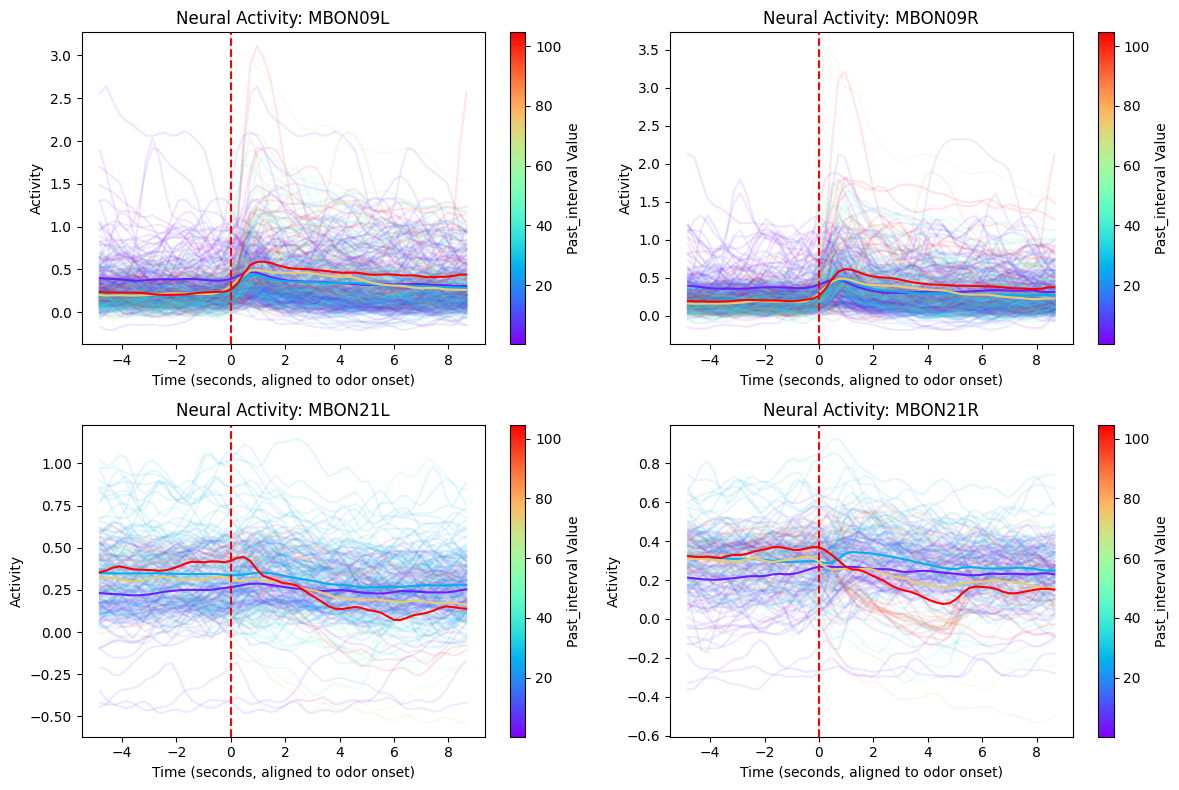

In [151]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,bounds=[10, 50, 100],percentile_range=[0, 95])

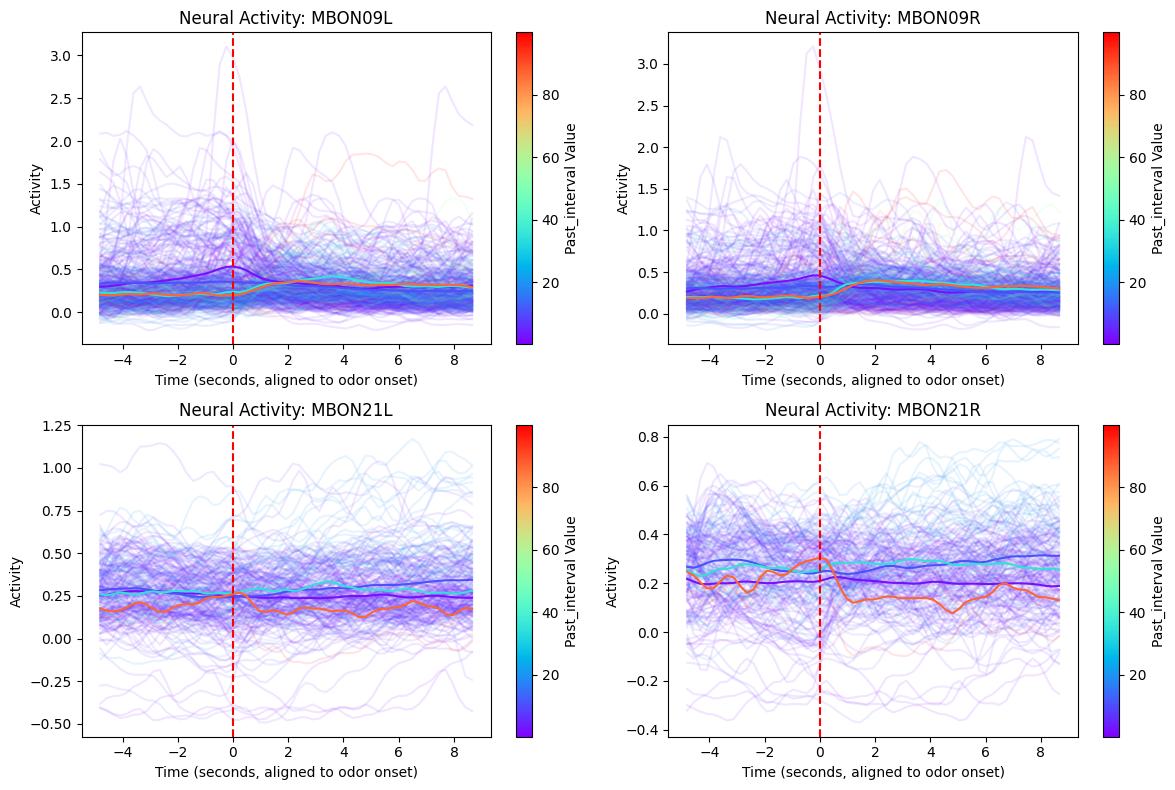

In [154]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,bounds=[5, 25, 50],is_onset=False,percentile_range=[0, 98])

#### MBON09/21 response colored by prior duration

In [155]:
combined_df.columns

Index(['time', 'fwV', 'sideV', 'yawV', 'heading', 'abssideV', 'absyawV',
       'net_motion', 'net_motion_state', 'heading_adj', 'odor', 'odor_state',
       'xPos', 'yPos', 'speed', 'theta_g', 'rho_t', 'event_duration',
       'past_interval', 'prior_event_duration', 'heading_avg',
       'surprise_index', 'adaptation_index', 'novelty_score',
       'burstiness_score', 'MBON09R', 'MBON21R', 'flyid', 'trialid', 'MBON09L',
       'hDeltaB_0', 'hDeltaB_1', 'hDeltaB_2', 'hDeltaB_3', 'hDeltaB_4',
       'hDeltaB_5', 'hDeltaB_6', 'hDeltaB_7', 'hDeltaB_8', 'hDeltaB_9',
       'hDeltaB_10', 'hDeltaB_11', 'hDeltaB_12', 'hDeltaB_13', 'hDeltaB_14',
       'hDeltaB_15', 'hDeltaB_16', 'hDeltaB_17', 'hDeltaB_18', 'hDeltaB_19',
       'hDeltaB_20', 'hDeltaB_21', 'phase', 'baseline', 'amplitude',
       'phase_error', 'baseline_error', 'amplitude_error', 'hDeltaB_22',
       'hDeltaB_23', 'hDeltaB_24', 'hDeltaB_25', 'hDeltaB_26', 'hDeltaB_27',
       'MBON21L'],
      dtype='object')

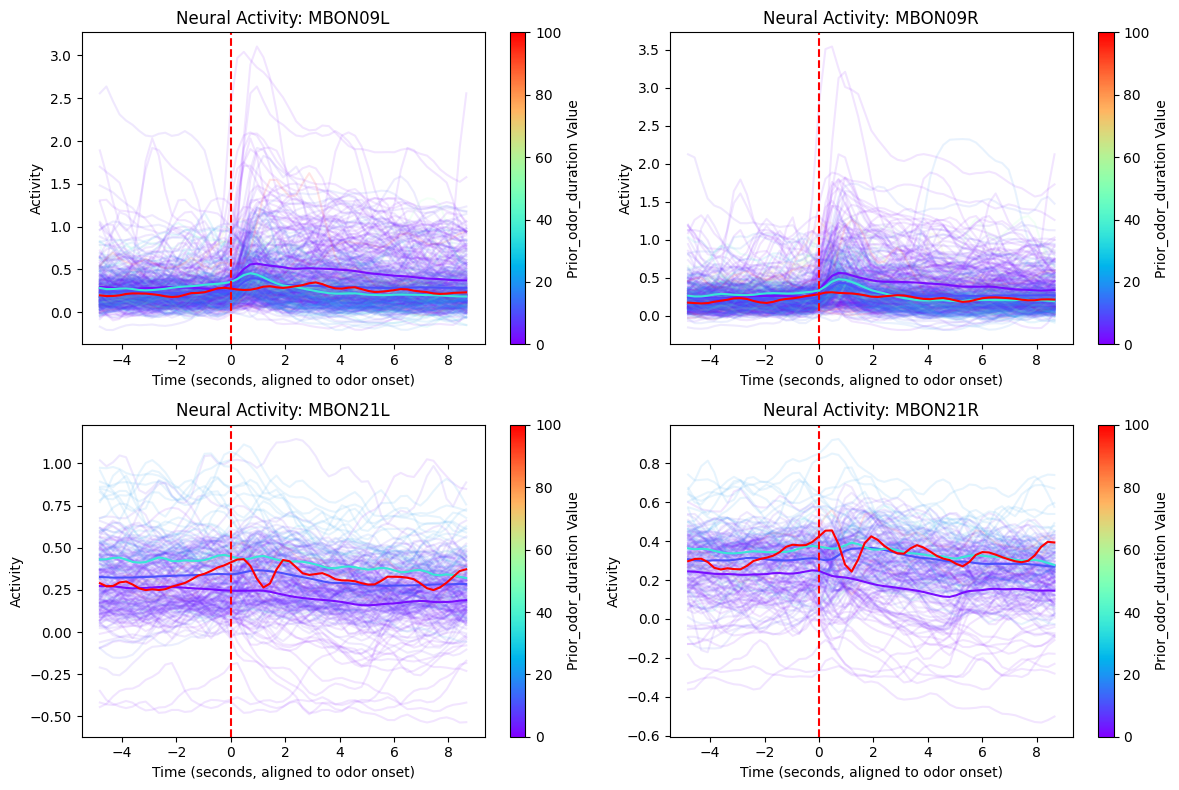

In [ ]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,plot_kw = 'prior_event_duration',bounds=[5, 20, 70])

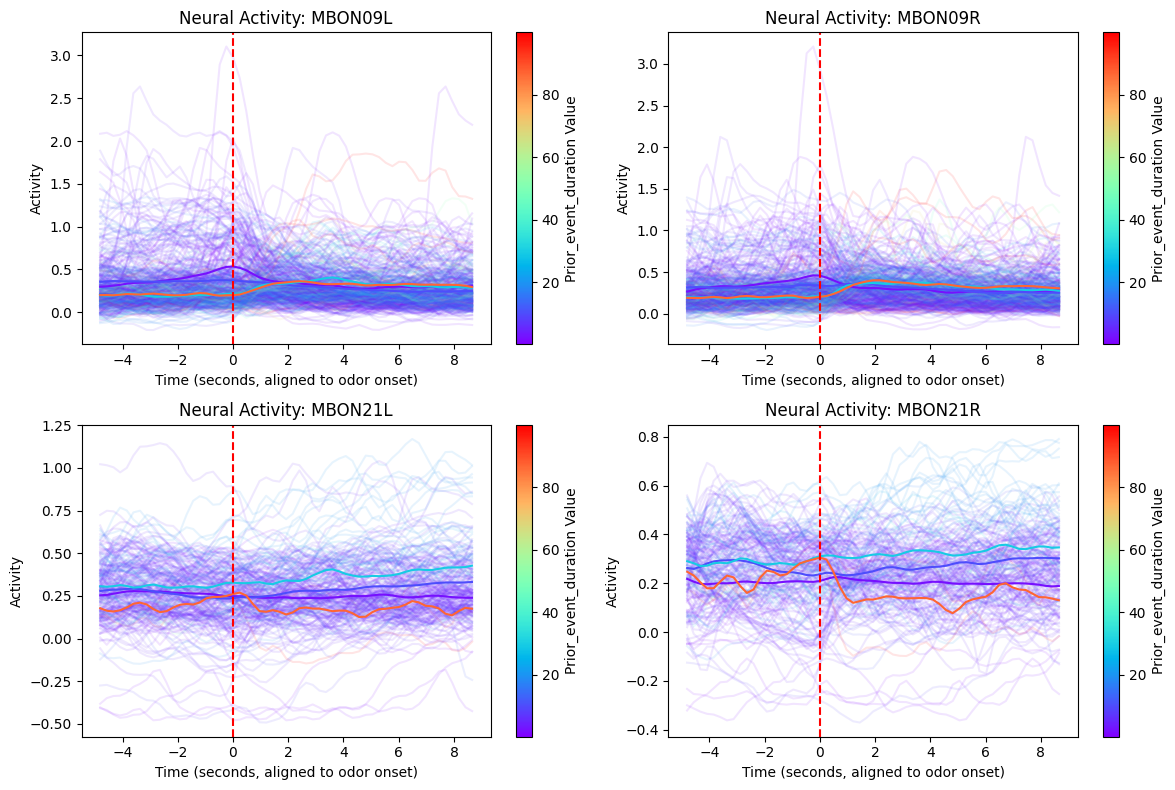

In [158]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,plot_kw = 'prior_event_duration',is_onset=False,bounds=[5, 20, 50],percentile_range=[0, 98])

#### MBON09/21 response colored by duration

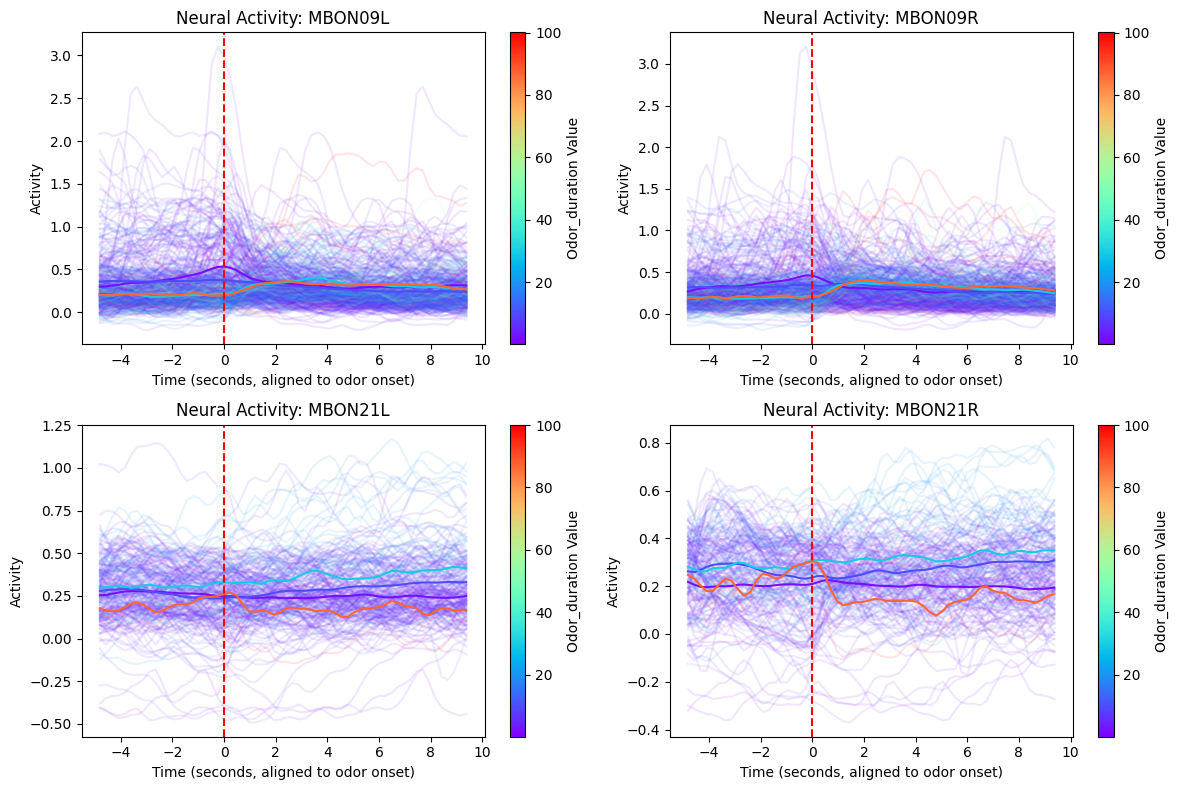

In [128]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_kw = 'odor_duration',is_onset= False, bounds=[5, 20, 50])

#### MBON09/21 response colored by adaptation index

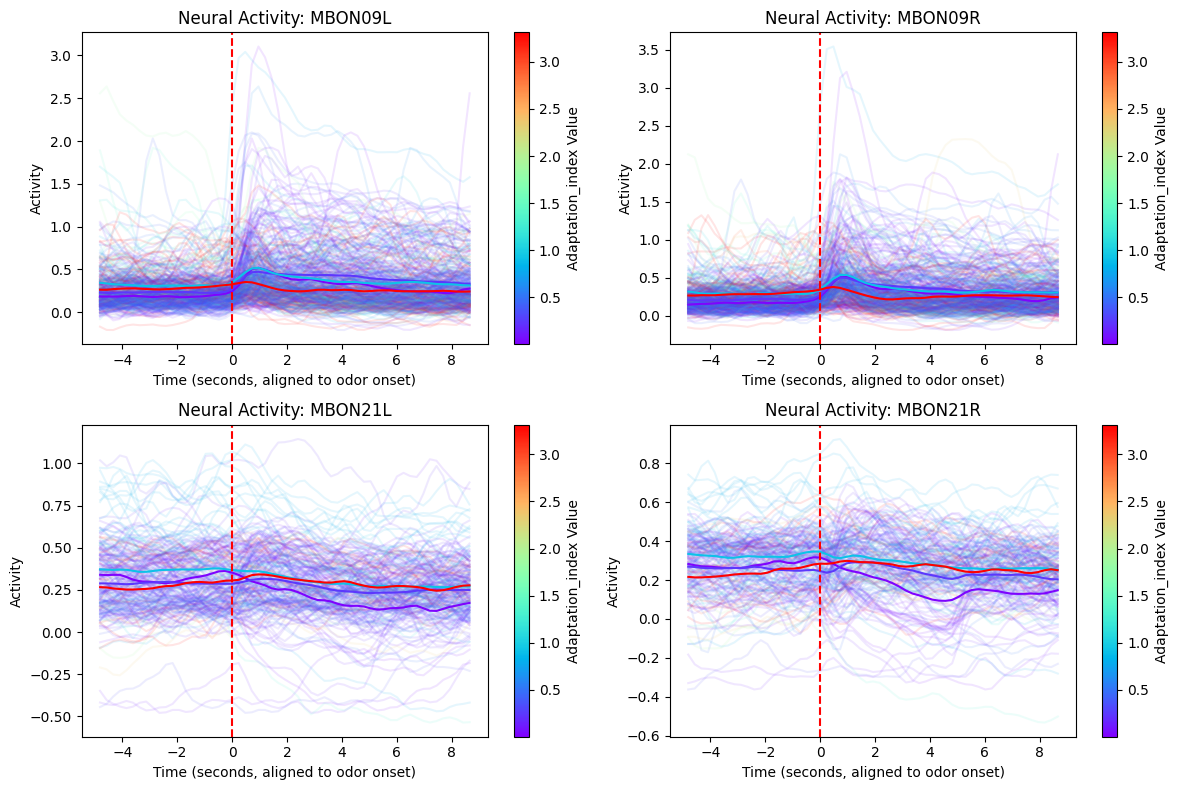

In [143]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,plot_kw = 'adaptation_index',bounds=[0.05,0.5,2])

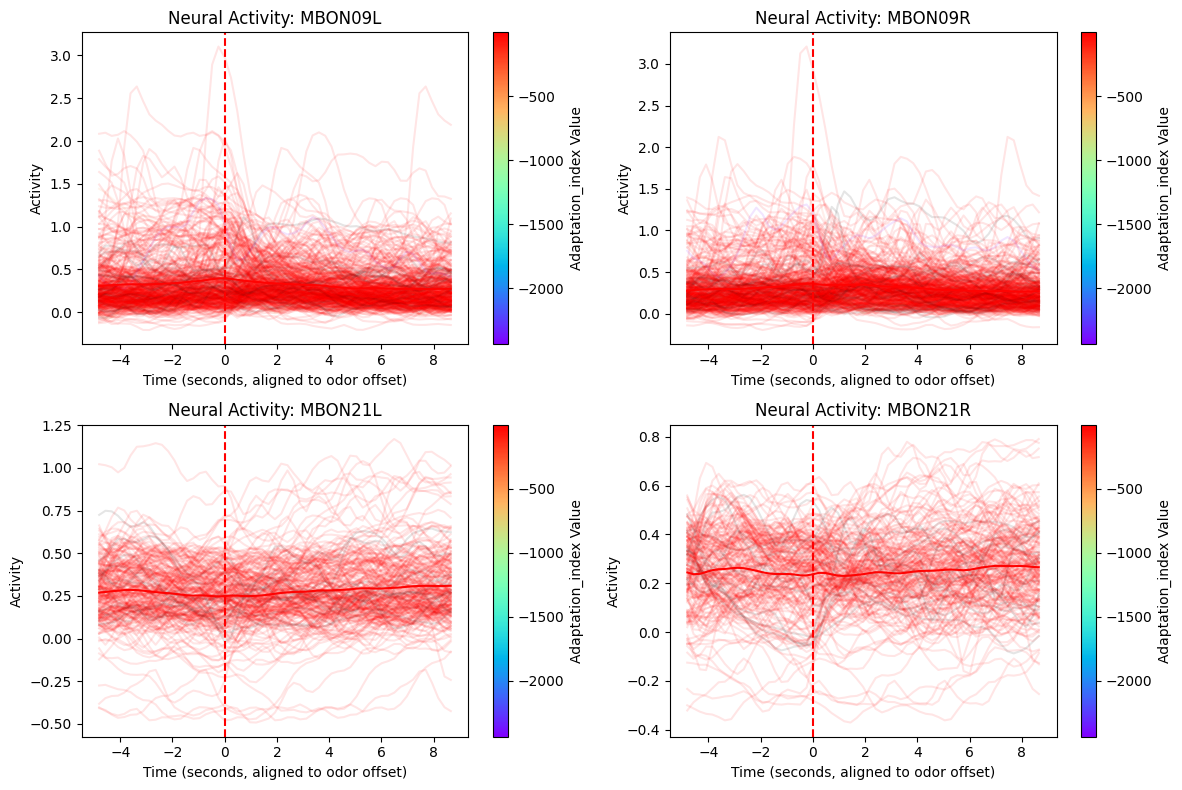

In [161]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=37,plot_kw = 'adaptation_index',is_onset=False,bounds=[0.05,0.5,2])

#### hDeltaB amplitude and mean responses colored by interval

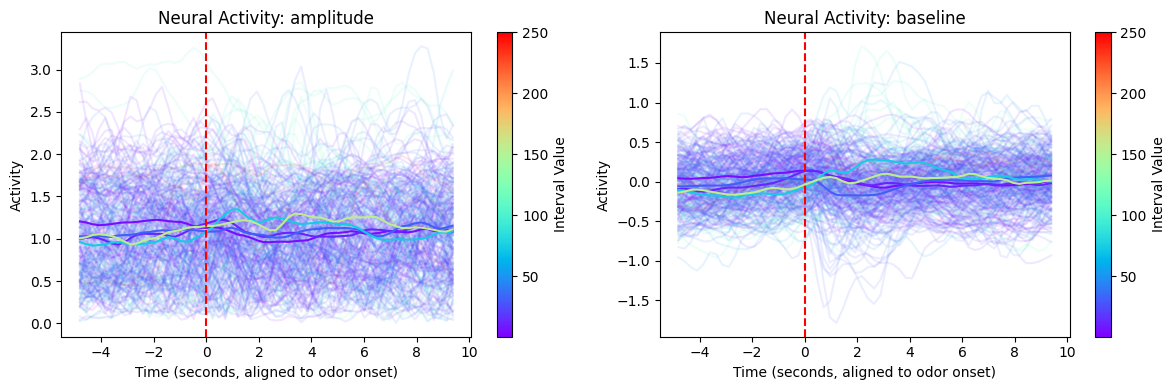

In [56]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],bounds=[10, 20, 50, 100])

#### hDeltaB amplitude and mean responses colored by duration

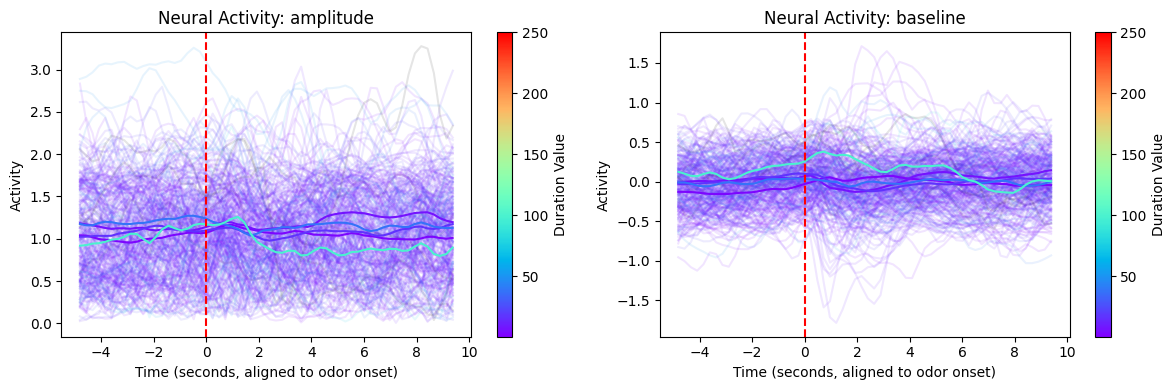

In [63]:
plot_neural_activity(combined_df, pre_window_size=20, post_window_size=40,plot_columns=["amplitude","baseline"],plot_kw = 'duration',bounds=[5, 10, 25,60])

#### FwV and yawV responses

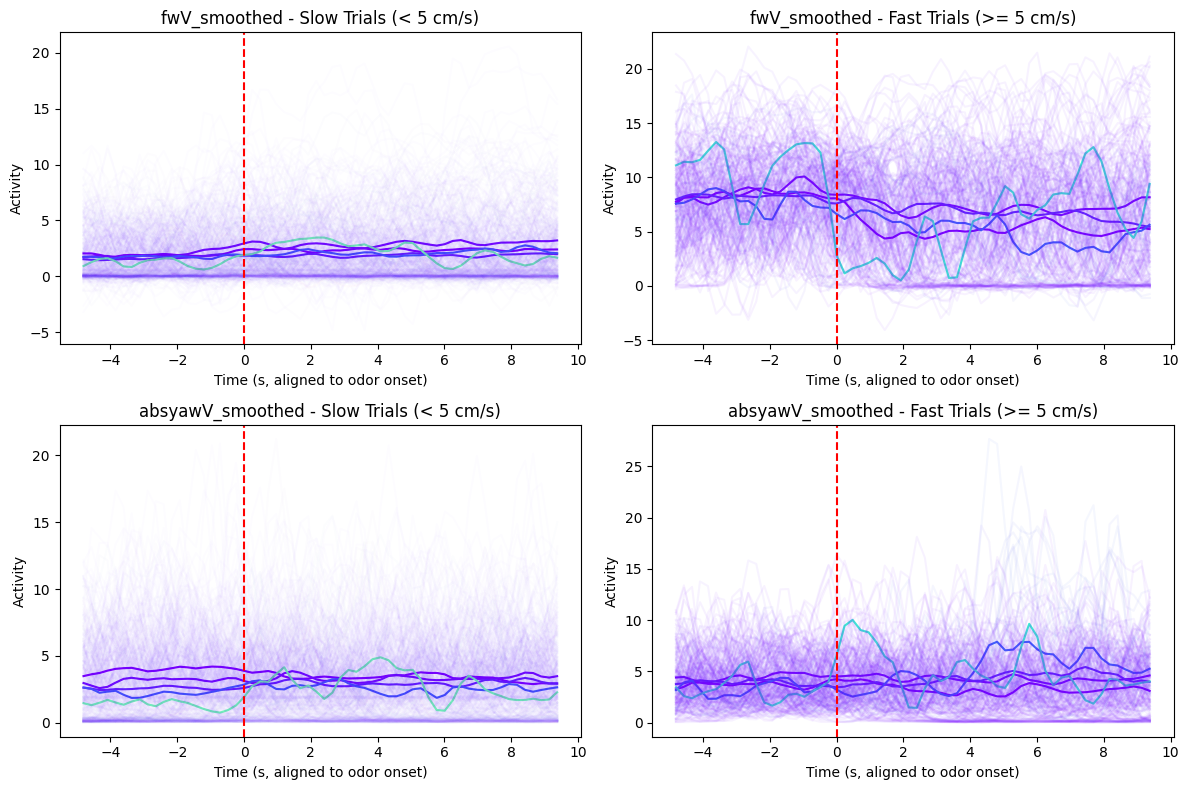

In [91]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1,velocity_threshold=5,bounds=[10, 25, 100, 200])

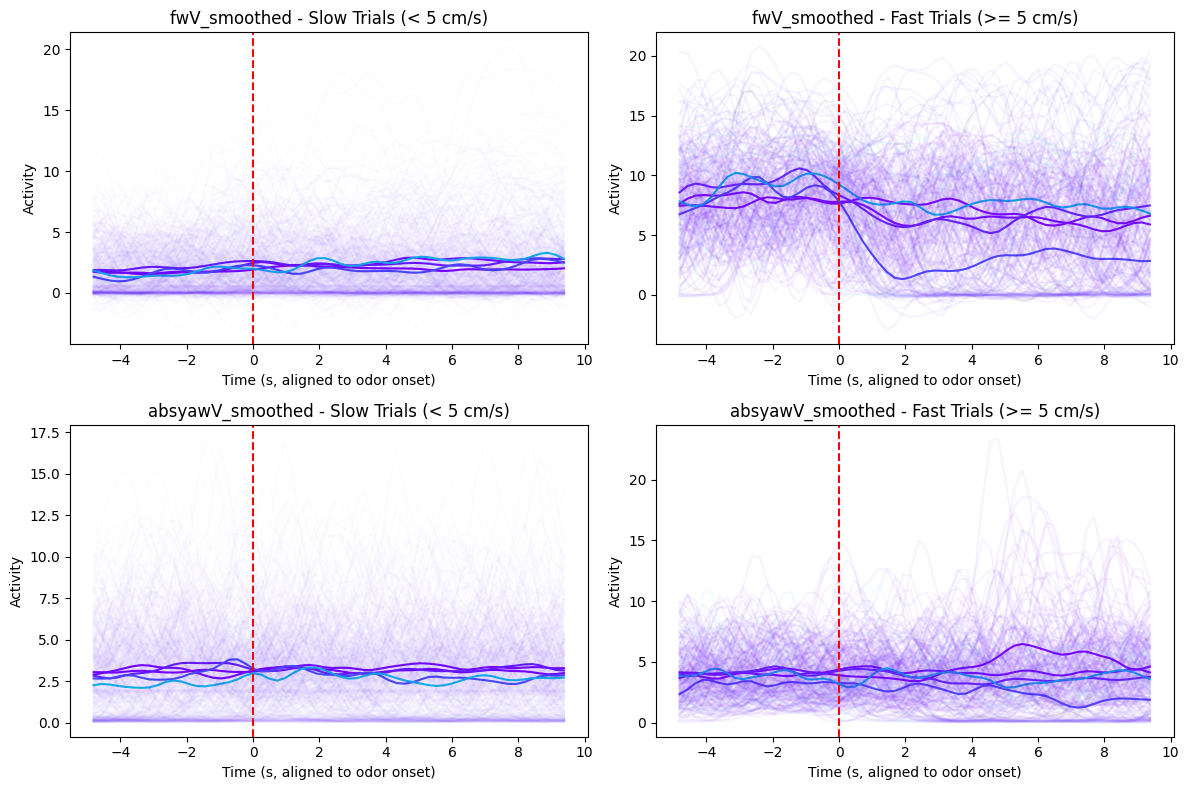

In [92]:
plot_neural_activity_2(combined_df, pre_window_size=20, post_window_size=40, plot_columns=["fwV", "absyawV"],sigma = 1.5,plot_kw = 'duration', velocity_threshold=5,bounds=[5, 10, 25, 50])